In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
from scipy.special import hankel1
from scipy.constants import pi, hbar

In [3]:
def generate_circular_lattice(radius=2, spacing=1, n=None):
    if n is None:
        n = int(radius/spacing)
    
    x = np.linspace(-radius, radius, n)
    y = np.linspace(-radius, radius, n)
    X, Y = np.meshgrid(x, y)

    # mask out the points outside the circle
    R = np.sqrt(X**2 + Y**2)
    mask = R <= radius

    # generate a mesh of points in the circle
    X = X[mask]
    Y = Y[mask]
    return X, Y

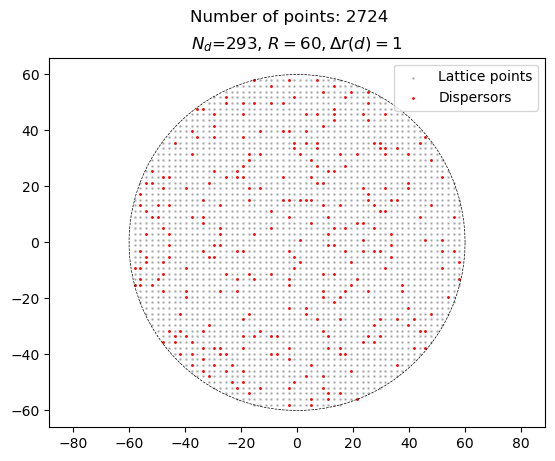

In [4]:
R=40
R=60
spacing=1

X,Y=generate_circular_lattice(radius=R, spacing=spacing)

# choose each point with probability p
p=.1
np.random.seed(42) # !!!for reproducibility
mask = np.random.rand(len(X)) < p
X_dispersors=X[mask]
Y_dispersors=Y[mask]

plt.scatter(X, Y, s=1, label='Lattice points', color=(0,0,0,0.2))
plt.scatter(X_dispersors, Y_dispersors, s=1, label='Dispersors', c='r')
plt.title(f'$N_d$={len(X_dispersors)}, $R={R}, \Delta r (d)={spacing}$')
plt.suptitle(f'Number of points: {len(X)}')
# print(f'Number of dispersors: {len(X_dispersors)}')
# plot a circle of radius R
t = np.linspace(0, 2*pi, 100)
plt.plot(R*np.cos(t), R*np.sin(t), 'k--', linewidth=0.5)
plt.legend()
plt.axis('equal');


In [5]:
m_matrix = np.zeros((len(X_dispersors), len(Y_dispersors)), dtype=np.complex128)
energy = 1
d=1
a_eff = 2.2
k=np.sqrt(2*energy)/d

gamma_euler = 0.57721566490153286060

for i, (x, y) in enumerate(zip(X_dispersors, Y_dispersors)):
    for j, (x_prime, y_prime) in enumerate(zip(X_dispersors, Y_dispersors)):
        if i == j:
            m_matrix[i, j] = np.log(k*a_eff*np.exp(gamma_euler))-1j*np.pi/2
        else:
            m_matrix[i, j] = -1j*np.pi/4*hankel1(0, k*np.sqrt((x-x_prime)**2+(y-y_prime)**2))

In [25]:
def generate_diag_off_diag_matrices_v2(k, a_eff, X_dispersors, Y_dispersors):
    diagonal_terms = np.zeros((len(X_dispersors), len(Y_dispersors)), dtype=np.complex128)
    off_diagonal_terms = np.zeros((len(X_dispersors), len(Y_dispersors)), dtype=np.complex128)

    for i, (x, y) in enumerate(zip(X_dispersors, Y_dispersors)):
        for j, (x_prime, y_prime) in enumerate(zip(X_dispersors, Y_dispersors)):
            if i == j:
                diagonal_terms[i, j] = np.log(k*a_eff*np.exp(gamma_euler))-1j*np.pi/2
            else:
                off_diagonal_terms[i, j] = -1j*np.pi/2*hankel1(0, k*np.sqrt((x-x_prime)**2+(y-y_prime)**2))
    return diagonal_terms, off_diagonal_terms

diagonal_terms = np.zeros((len(X_dispersors), len(Y_dispersors)), dtype=np.complex128)
off_diagonal_terms = np.zeros((len(X_dispersors), len(Y_dispersors)), dtype=np.complex128)

for i, (x, y) in enumerate(zip(X_dispersors, Y_dispersors)):
    for j, (x_prime, y_prime) in enumerate(zip(X_dispersors, Y_dispersors)):
        if i == j:
            diagonal_terms[i, j] = np.log(k*a_eff*np.exp(gamma_euler))-1j*np.pi/2
        else:
            off_diagonal_terms[i, j] = -1j*np.pi/4*hankel1(0, k*np.sqrt((x-x_prime)**2+(y-y_prime)**2))

In [31]:
def generate_diag_off_diag_matrices(k, a_eff, X_dispersors, Y_dispersors):
    diagonal_terms = np.zeros((len(X_dispersors), len(Y_dispersors)), dtype=np.complex128)
    off_diagonal_terms = np.zeros((len(X_dispersors), len(Y_dispersors)), dtype=np.complex128)

    for i, (x, y) in enumerate(zip(X_dispersors, Y_dispersors)):
        for j in range(i+1, len(X_dispersors)):
            x_prime, y_prime = X_dispersors[j], Y_dispersors[j]
            off_diagonal_terms[i, j] = -1j*np.pi/2*hankel1(0, k*np.sqrt((x-x_prime)**2+(y-y_prime)**2))
            
    off_diagonal_terms = off_diagonal_terms + off_diagonal_terms.T
    diagonal_terms=np.diag([np.log(k*a_eff*np.exp(gamma_euler))-1j*np.pi/2]*len(X_dispersors))
    return diagonal_terms, off_diagonal_terms

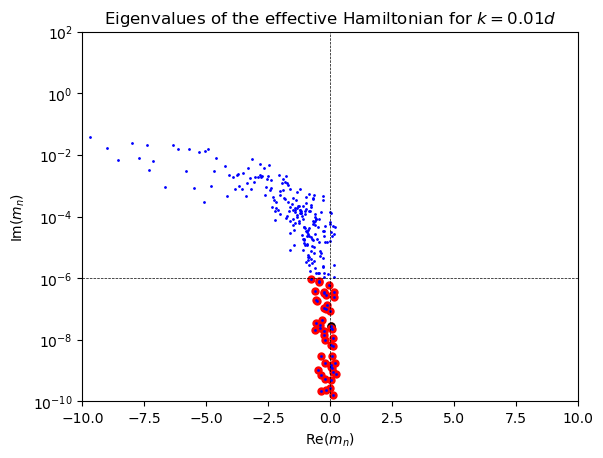

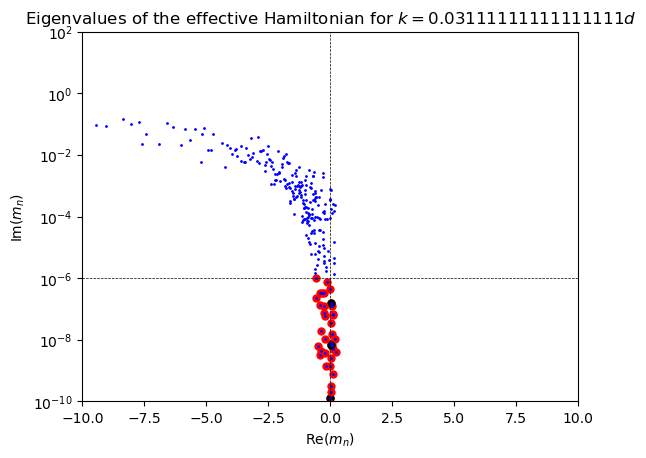

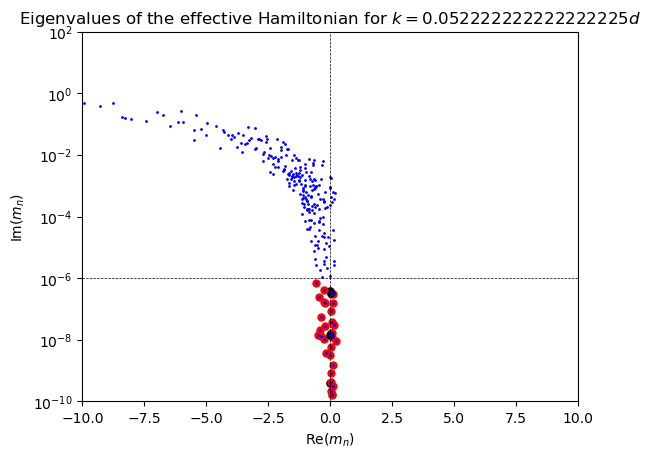

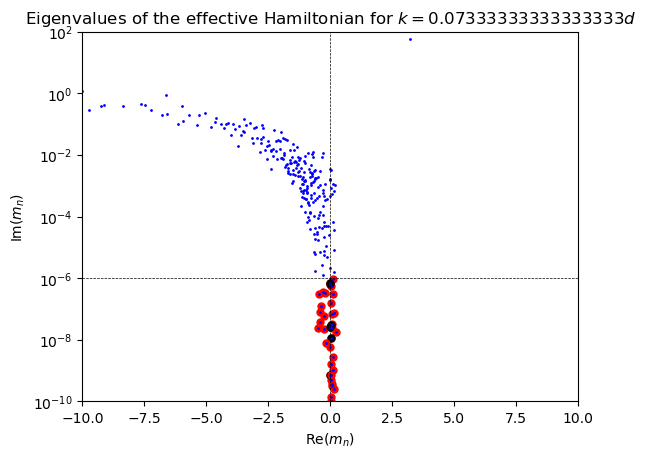

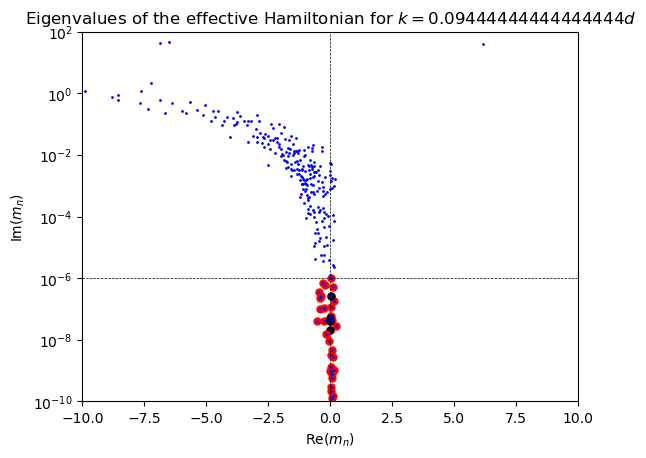

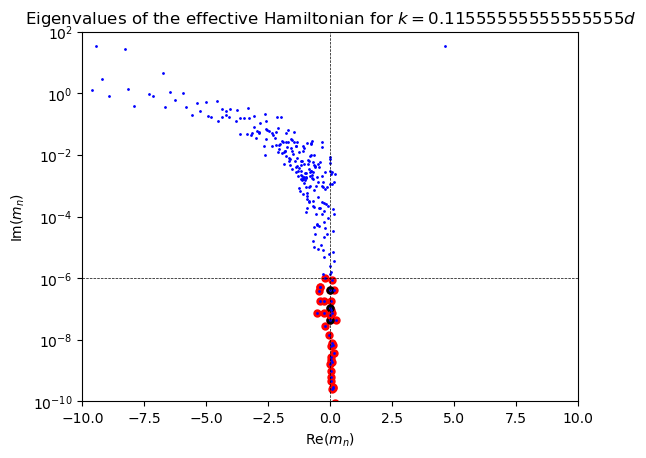

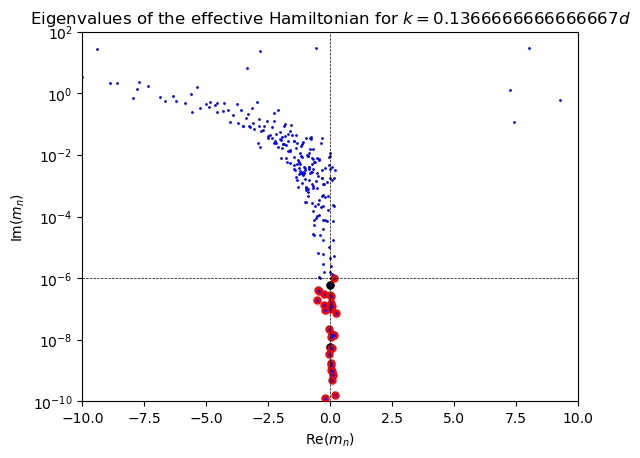

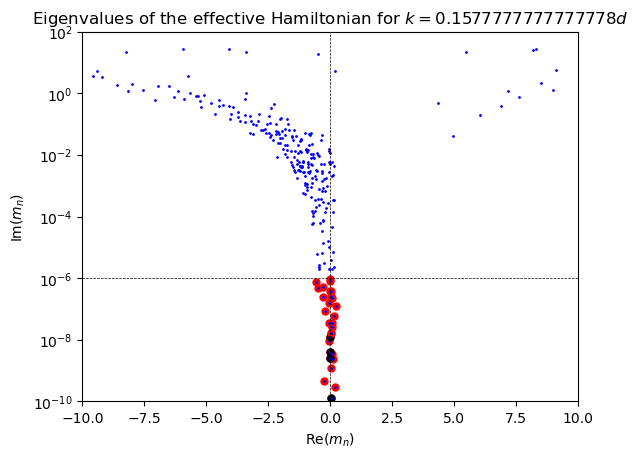

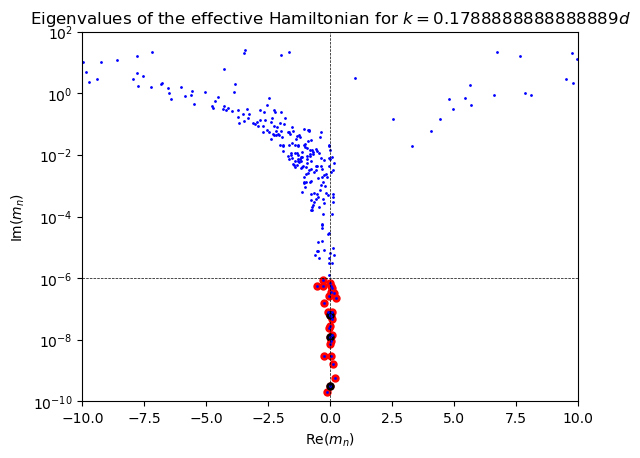

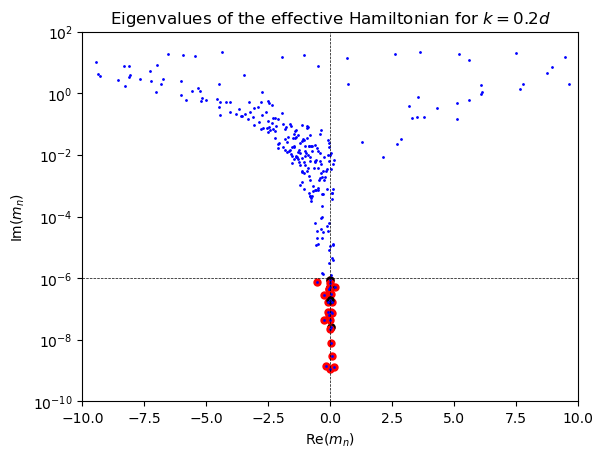

[2, 3, 4, 6, 4, 3, 2, 4, 4, 4]


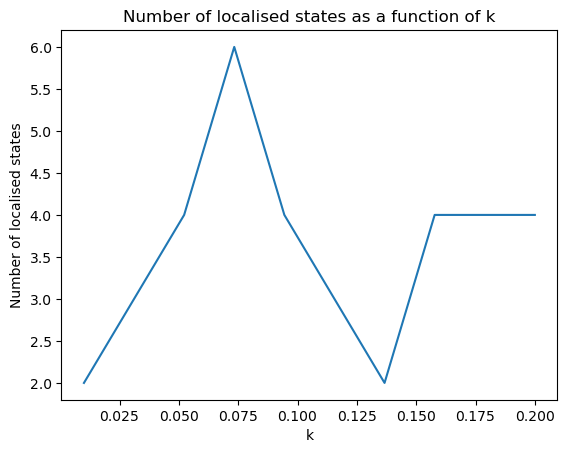

In [12]:
k=0.1
k_vals=np.linspace(0.01, 0.2, 10)
a_eff_vals=np.linspace(0.01, 5, 50)
# k_vals=[0.106]
loc_states_per_k=[]
a_eff=2
# for a_eff in a_eff_vals:
for k in k_vals:
    num_loc_states=0
    diag,offdiag=generate_diag_off_diag_matrices(k, a_eff, X_dispersors, Y_dispersors)
    m_matrix = diag*np.eye(len(X_dispersors))+offdiag
    off_diag_eigvals, off_diagonal_eigvecs = np.linalg.eig(offdiag)
    eigvals, eigvecs = np.linalg.eig(m_matrix)
    ones = np.ones(shape=off_diag_eigvals.shape)
    real_eigvals = (np.log(a_eff*k/2)+gamma_euler-1j*np.pi/2)*ones+off_diag_eigvals
    for i,q_n in enumerate(off_diag_eigvals):
        if (np.abs(np.imag(q_n)-np.pi/2)<1e-6):
            plt.plot(np.real(off_diag_eigvals[i])+gamma_euler+np.log(a_eff*k/2), np.abs(np.imag(real_eigvals[i])), 'or',markersize=5)
            # print(np.abs(np.real(q_n)+gamma_euler+np.log(k*a_eff/2)))
            if (np.abs(np.real(q_n)+gamma_euler+np.log(k*a_eff/2))<1e-2):
                num_loc_states+=1
                plt.plot(np.real(q_n)+gamma_euler+np.log(a_eff*k/2), np.abs(np.imag(real_eigvals[i])), 'ok',markersize=5)
    loc_states_per_k.append(num_loc_states)
    plt.plot(np.real(off_diag_eigvals)+gamma_euler+np.log(a_eff*k/2), np.abs(np.imag(real_eigvals)), 'ob',markersize=1)
    plt.xlabel('Re($m_n$)')
    plt.ylabel('Im($m_n$)')
    plt.title(f'Eigenvalues of the effective Hamiltonian for $k={k}d$')
    plt.semilogy()
    plt.ylim(1e-10, 1e2)
    plt.xlim(-1e1, 1e1)
    # plt.xlim(-1,0)
    plt.hlines(1e-6, -1e1, 1e1, linestyles='dashed', color='black', linewidth=0.5)
    plt.vlines(0, 1e-10, 1e2, linestyles='dashed', color='black', linewidth=0.5)
    plt.show()
    
print(loc_states_per_k)
plt.plot(k_vals,loc_states_per_k)
plt.xlabel('k')
plt.ylabel('Number of localised states')
plt.title('Number of localised states as a function of k')
plt.show()

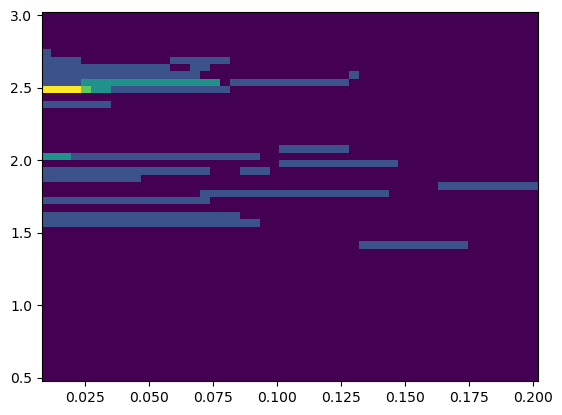

In [23]:
k_vals=np.linspace(0.01, 0.2, 50)
a_eff_vals=np.linspace(0.5, 3, 50)
loc_states_heatmap=np.zeros((len(k_vals), len(a_eff_vals)))
for i,a_eff in enumerate(a_eff_vals):
    for j,k in enumerate(k_vals):
        diag,offdiag=generate_diag_off_diag_matrices(k, a_eff, X_dispersors, Y_dispersors)
        m_matrix = diag*np.eye(len(X_dispersors))+offdiag
        off_diag_eigvals, off_diagonal_eigvecs = np.linalg.eig(offdiag)
        eigvals, eigvecs = np.linalg.eig(m_matrix)
        ones = np.ones(shape=off_diag_eigvals.shape)
        real_eigvals = (np.log(a_eff*k/2)+gamma_euler-1j*np.pi/2)*ones+off_diag_eigvals
        for q_n in off_diag_eigvals:
            if (np.abs(np.imag(q_n)-np.pi/2)<1e-6):
                if (np.abs(np.real(q_n)+gamma_euler+np.log(k*a_eff/2))<1e-2):
                    loc_states_heatmap[i,j]+=1

plt.pcolor(k_vals, a_eff_vals, loc_states_heatmap)

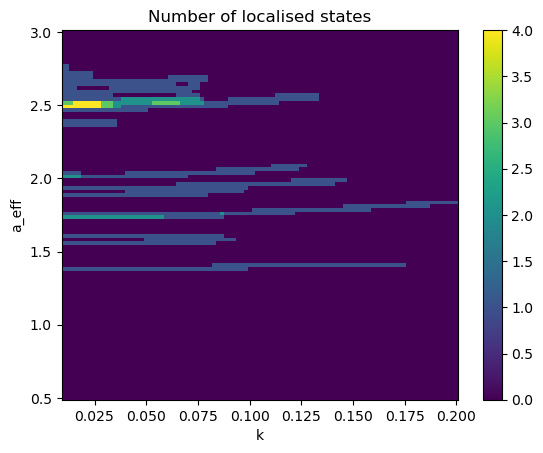

In [24]:
k_vals=np.linspace(0.01, 0.2, 100)
a_eff_vals=np.linspace(0.5, 3, 100)
loc_states_heatmap=np.zeros((len(k_vals), len(a_eff_vals)))
for i,a_eff in enumerate(a_eff_vals):
    for j,k in enumerate(k_vals):
        diag,offdiag=generate_diag_off_diag_matrices(k, a_eff, X_dispersors, Y_dispersors)
        m_matrix = diag*np.eye(len(X_dispersors))+offdiag
        off_diag_eigvals, off_diagonal_eigvecs = np.linalg.eig(offdiag)
        eigvals, eigvecs = np.linalg.eig(m_matrix)
        ones = np.ones(shape=off_diag_eigvals.shape)
        real_eigvals = (np.log(a_eff*k/2)+gamma_euler-1j*np.pi/2)*ones+off_diag_eigvals
        for q_n in off_diag_eigvals:
            if (np.abs(np.imag(q_n)-np.pi/2)<1e-6):
                if (np.abs(np.real(q_n)+gamma_euler+np.log(k*a_eff/2))<1e-2):
                    loc_states_heatmap[i,j]+=1

plt.pcolor(k_vals, a_eff_vals, loc_states_heatmap)
plt.ylabel('a_eff')
plt.xlabel('k')
plt.title('Number of localised states')
plt.colorbar()

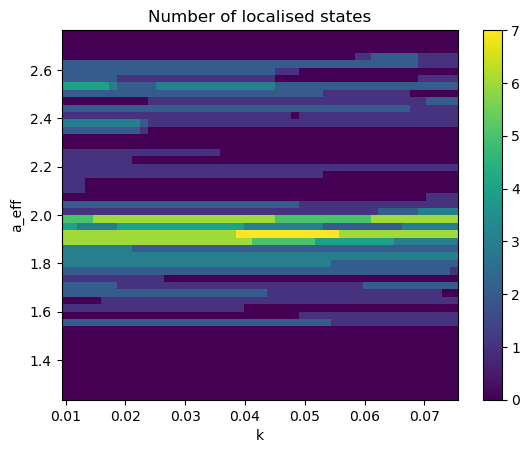

In [13]:
k_vals=np.linspace(0.01, 0.075, 50)
a_eff_vals=np.linspace(1.25, 2.75, 50)
loc_states_heatmap=np.zeros((len(k_vals), len(a_eff_vals)))
for i,a_eff in enumerate(a_eff_vals):
    for j,k in enumerate(k_vals):
        diag,offdiag=generate_diag_off_diag_matrices(k, a_eff, X_dispersors, Y_dispersors)
        m_matrix = diag*np.eye(len(X_dispersors))+offdiag
        off_diag_eigvals, off_diagonal_eigvecs = np.linalg.eig(offdiag)
        eigvals, eigvecs = np.linalg.eig(m_matrix)
        ones = np.ones(shape=off_diag_eigvals.shape)
        real_eigvals = (np.log(a_eff*k/2)+gamma_euler-1j*np.pi/2)*ones+off_diag_eigvals
        for q_n in off_diag_eigvals:
            if (np.abs(np.imag(q_n)-np.pi/2)<1e-6):
                if (np.abs(np.real(q_n)+gamma_euler+np.log(k*a_eff/2))<1e-2):
                    loc_states_heatmap[i,j]+=1

plt.pcolor(k_vals, a_eff_vals, loc_states_heatmap)
plt.ylabel('a_eff')
plt.xlabel('k')
plt.title('Number of localised states')
plt.colorbar()

In [8]:
R=40
spacing=1

X,Y=generate_circular_lattice(radius=R, spacing=spacing)

# choose each point with probability p
p=.1
np.random.seed(0) # !!!for reproducibility
mask = np.random.rand(len(X)) < p
X_dispersors=X[mask]
Y_dispersors=Y[mask]

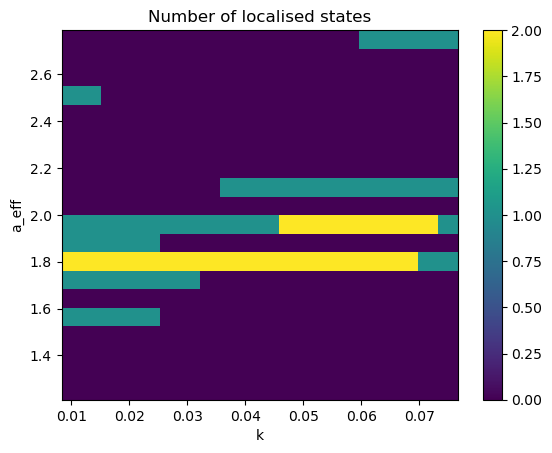

In [9]:
k_vals=np.linspace(0.01, 0.075, 20)
a_eff_vals=np.linspace(1.25, 2.75, 20)
loc_states_heatmap=np.zeros((len(k_vals), len(a_eff_vals)))
for i,a_eff in enumerate(a_eff_vals):
    for j,k in enumerate(k_vals):
        diag,offdiag=generate_diag_off_diag_matrices(k, a_eff, X_dispersors, Y_dispersors)
        m_matrix = diag*np.eye(len(X_dispersors))+offdiag
        off_diag_eigvals, off_diagonal_eigvecs = np.linalg.eig(offdiag)
        eigvals, eigvecs = np.linalg.eig(m_matrix)
        ones = np.ones(shape=off_diag_eigvals.shape)
        real_eigvals = (np.log(a_eff*k/2)+gamma_euler-1j*np.pi/2)*ones+off_diag_eigvals
        for q_n in off_diag_eigvals:
            if (np.abs(np.imag(q_n)-np.pi/2)<1e-6):
                if (np.abs(np.real(q_n)+gamma_euler+np.log(k*a_eff/2))<1e-2):
                    loc_states_heatmap[i,j]+=1

plt.pcolor(k_vals, a_eff_vals, loc_states_heatmap)
plt.ylabel('a_eff')
plt.xlabel('k')
plt.title('Number of localised states')
plt.colorbar()

In [23]:
from datetime import datetime

def plot_heatmap(loc_states_heatmap,k_range,a_eff_range, p, X_dispersors, seed):
    plt.pcolor(k_range, a_eff_range, loc_states_heatmap)
    plt.ylabel('a_eff')
    plt.xlabel('k')
    plt.suptitle('Number of localised states')
    plt.title(f'p={p}, $N_d$={len(X_dispersors)}, seed = {seed}')
    plt.colorbar()
    date=datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
    # filename = f'heatmap_{p}_{len(X_dispersors)}_{seed}.png'
    filename = f'heatmap_{date}_{p}_{len(X_dispersors)}_{seed}.png'
    plt.savefig(filename)
    plt.show();
    
def heatmap_localization(R=40,seed=42,p=.1,k_range=[0.01,0.075,20],a_eff_range=[1.25,2.75,20],spacing=1):
    time1=datetime.now()
    X,Y=generate_circular_lattice(radius=R, spacing=spacing)
    np.random.seed(seed) 
    mask = np.random.rand(len(X)) < p
    X_dispersors=X[mask]
    Y_dispersors=Y[mask]
    time2=datetime.now()
    print(f'Generating the lattice took {time2-time1}')
    
    k_vals=np.linspace(k_range[0], k_range[1], k_range[2])
    a_eff_vals=np.linspace(a_eff_range[0], a_eff_range[1], a_eff_range[2])
    loc_states_heatmap=np.zeros((k_range[2], a_eff_range[2]))
    for i,a_eff in enumerate(a_eff_vals):
        for j,k in enumerate(k_vals):
            time1=datetime.now()
            _,offdiag=generate_diag_off_diag_matrices(k, a_eff, X_dispersors, Y_dispersors)
            time2=datetime.now()
            print(f'Generating the matrices took {time2-time1}')
            time1=datetime.now()
            off_diag_eigvals, _ = np.linalg.eig(offdiag)
            time2=datetime.now()
            print(f'Calculating the eigenvalues took {time2-time1}')
            time1=datetime.now()
            for q_n in off_diag_eigvals:
                if (np.abs(np.imag(q_n)-np.pi/2)<1e-6):
                    if (np.abs(np.real(q_n)+gamma_euler+np.log(k*a_eff/2))<1e-2):
                        loc_states_heatmap[i,j]+=1
            time2=datetime.now()
            print(f'Calculating the localised states took {time2-time1}')
    time1=datetime.now()
    plot_heatmap(loc_states_heatmap,k_vals,a_eff_vals, p, X_dispersors, seed)
    time2=datetime.now()
    print(f'Plotting the heatmap took {time2-time1}')
    return loc_states_heatmap

In [10]:
R=40
spacing=1

X,Y=generate_circular_lattice(radius=R, spacing=spacing)

# choose each point with probability p
p=.1
np.random.seed(1) # !!!for reproducibility
mask = np.random.rand(len(X)) < p
X_dispersors=X[mask]
Y_dispersors=Y[mask]

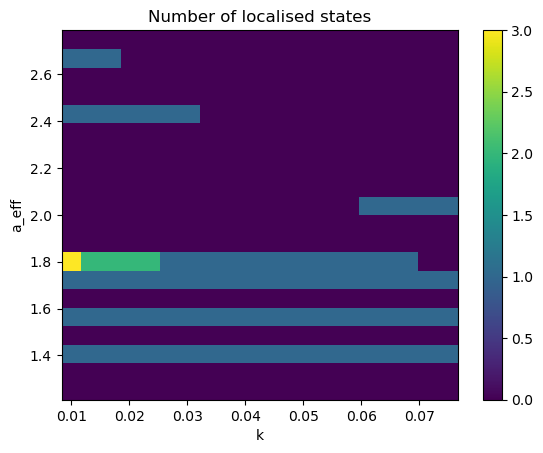

In [11]:
k_vals=np.linspace(0.01, 0.075, 20)
a_eff_vals=np.linspace(1.25, 2.75, 20)
loc_states_heatmap=np.zeros((len(k_vals), len(a_eff_vals)))
for i,a_eff in enumerate(a_eff_vals):
    for j,k in enumerate(k_vals):
        diag,offdiag=generate_diag_off_diag_matrices(k, a_eff, X_dispersors, Y_dispersors)
        m_matrix = diag*np.eye(len(X_dispersors))+offdiag
        off_diag_eigvals, off_diagonal_eigvecs = np.linalg.eig(offdiag)
        eigvals, eigvecs = np.linalg.eig(m_matrix)
        ones = np.ones(shape=off_diag_eigvals.shape)
        real_eigvals = (np.log(a_eff*k/2)+gamma_euler-1j*np.pi/2)*ones+off_diag_eigvals
        for q_n in off_diag_eigvals:
            if (np.abs(np.imag(q_n)-np.pi/2)<1e-6):
                if (np.abs(np.real(q_n)+gamma_euler+np.log(k*a_eff/2))<1e-2):
                    loc_states_heatmap[i,j]+=1

plt.pcolor(k_vals, a_eff_vals, loc_states_heatmap)
plt.ylabel('a_eff')
plt.xlabel('k')
plt.title('Number of localised states')
plt.colorbar()

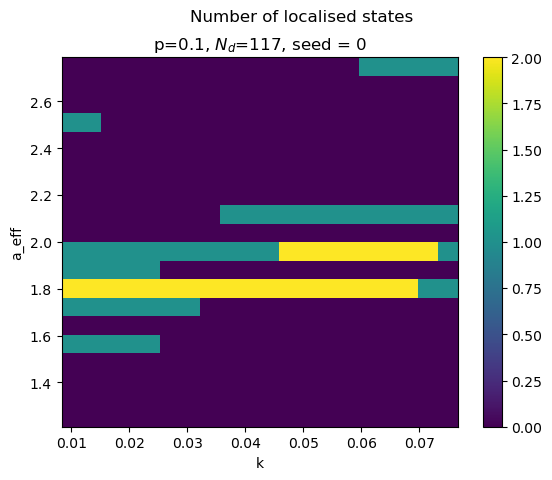

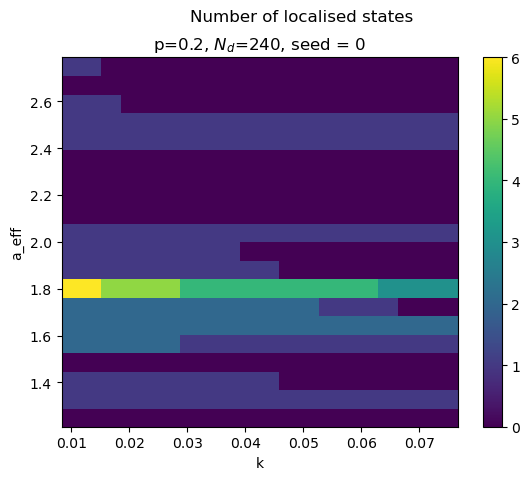

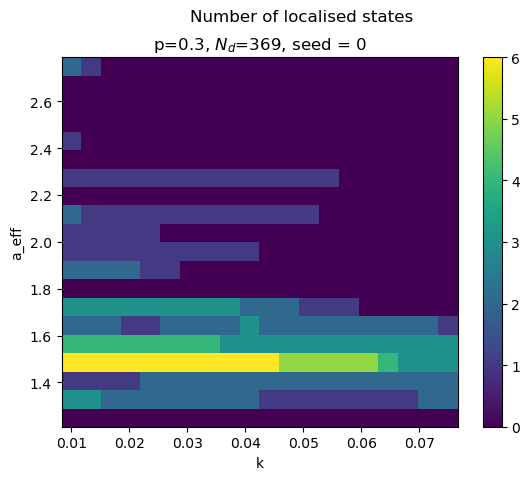

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [3., 3., 2., 2., 2., 2., 2., 2., 2., 2., 1., 1., 1., 1., 1., 1.,
        1., 1., 2., 2.],
       [1., 1., 1., 1., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
        2., 2., 2., 2.],
       [6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 5., 5., 5., 5., 5.,
        4., 3., 3., 3.],
       [4., 4., 4., 4., 4., 4., 4., 4., 3., 3., 3., 3., 3., 3., 3., 3.,
        3., 3., 3., 3.],
       [2., 2., 2., 1., 1., 2., 2., 2., 2., 3., 2., 2., 2., 2., 2., 2.,
        2., 2., 2., 1.],
       [3., 3., 3., 3., 3., 3., 3., 3., 3., 2., 2., 2., 1., 1., 1., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [2., 2., 2., 2., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [1., 1., 1., 1., 1., 0.

In [13]:
heatmap_localization(R=40,seed=0,p=.1,k_range=[0.01,0.075,20],a_eff_range=[1.25,2.75,20],spacing=1)
heatmap_localization(R=40,seed=0,p=.2,k_range=[0.01,0.075,20],a_eff_range=[1.25,2.75,20],spacing=1)
heatmap_localization(R=40,seed=0,p=.3,k_range=[0.01,0.075,20],a_eff_range=[1.25,2.75,20],spacing=1)

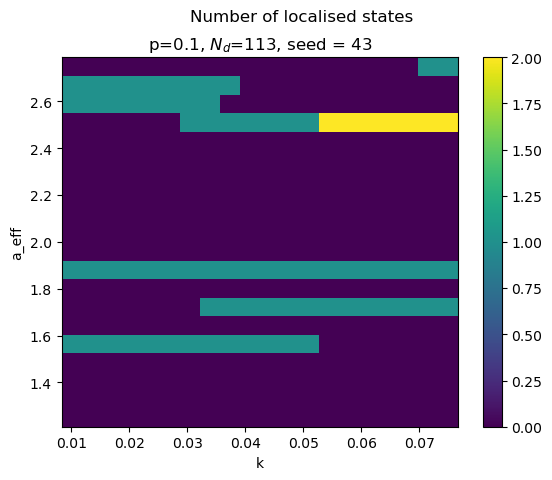

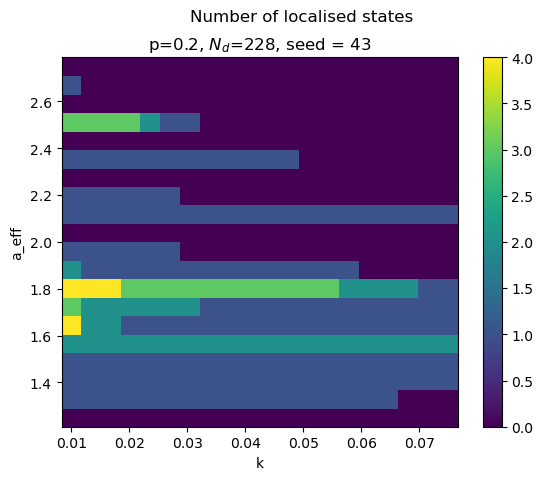

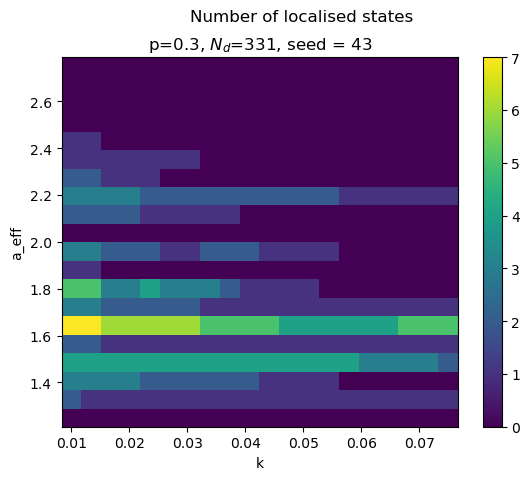

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [2., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1.],
       [3., 3., 3., 3., 2., 2., 2., 2., 2., 2., 1., 1., 1., 1., 0., 0.,
        0., 0., 0., 0.],
       [4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 3.,
        3., 3., 3., 2.],
       [2., 2., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1.],
       [7., 7., 6., 6., 6., 6., 6., 5., 5., 5., 5., 4., 4., 4., 4., 4.,
        4., 5., 5., 5.],
       [3., 3., 2., 2., 2., 2., 2., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1.],
       [5., 5., 3., 3., 4., 3., 3., 3., 2., 1., 1., 1., 1., 0., 0., 0.,
        0., 0., 0., 0.],
       [1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [3., 3., 2., 2., 2., 1., 1., 2., 2., 2., 1., 1., 1., 1., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.

In [14]:
heatmap_localization(R=40,seed=43,p=.1,k_range=[0.01,0.075,20],a_eff_range=[1.25,2.75,20],spacing=1)
heatmap_localization(R=40,seed=43,p=.2,k_range=[0.01,0.075,20],a_eff_range=[1.25,2.75,20],spacing=1)
heatmap_localization(R=40,seed=43,p=.3,k_range=[0.01,0.075,20],a_eff_range=[1.25,2.75,20],spacing=1)

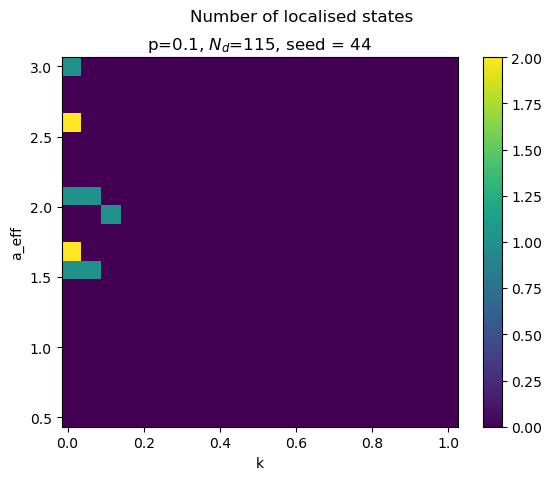

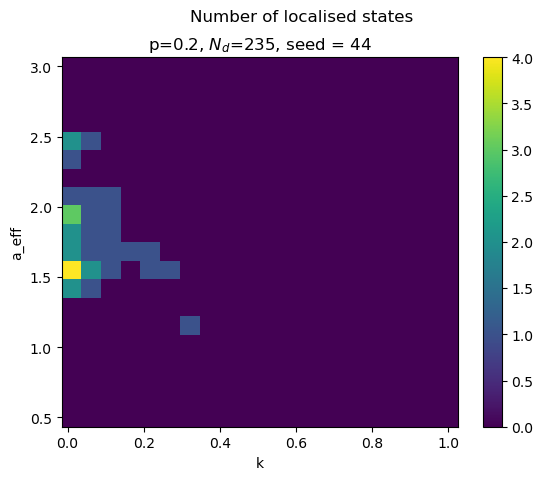

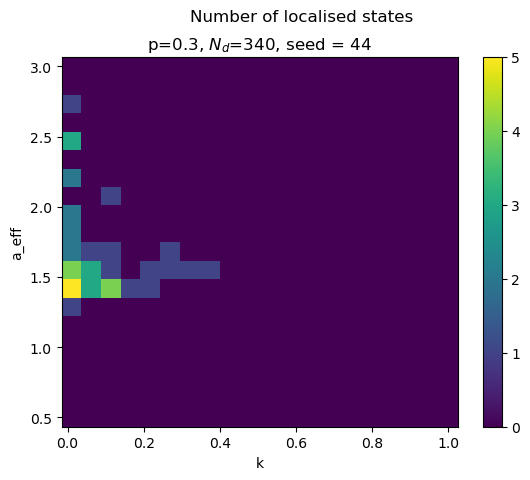

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [5., 3., 4., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [4., 3., 1., 0., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [2., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [2., 0., 0., 0., 0., 0.

In [16]:
heatmap_localization(R=40,seed=44,p=.1,k_range=[0.01,1,20],a_eff_range=[0.5,3,20],spacing=1)
heatmap_localization(R=40,seed=44,p=.2,k_range=[0.01,1,20],a_eff_range=[0.5,3,20],spacing=1)
heatmap_localization(R=40,seed=44,p=.3,k_range=[0.01,1,20],a_eff_range=[0.5,3,20],spacing=1)

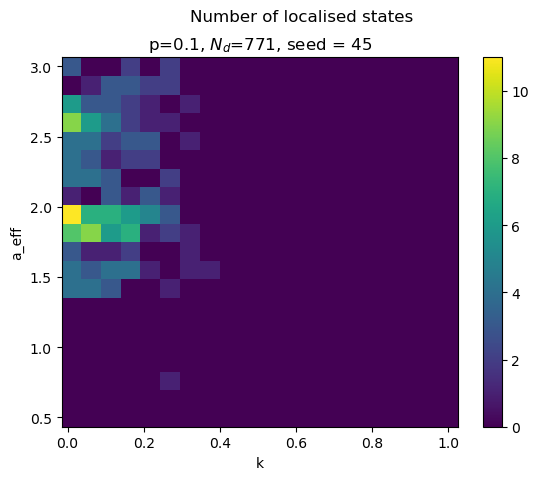

array([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 4.,  4.,  3.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 4.,  3.,  4.,  4.,  1.,  0.,  1.,  1.,  0.,  0.,  0.,  

In [21]:
heatmap_localization(R=100,seed=45,p=.1,k_range=[0.01,1,20],a_eff_range=[0.5,3,20],spacing=1)

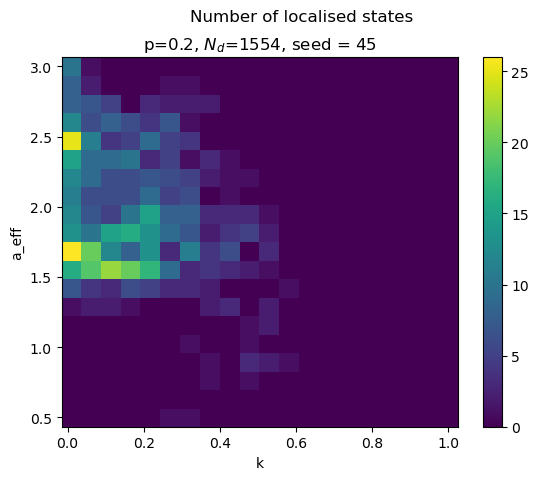

array([[ 0.,  0.,  0.,  0.,  0.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  1.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  3.,  2.,  1.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  1.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  2.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 1.,  2.,  2.,  1.,  0.,  0.,  0.,  2.,  3.,  0.,  2.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 7.,  4.,  3.,  6.,  5.,  3.,  3.,  2.,  0.,  0.,  0.,  1.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [16., 19., 22., 20., 17.,  9.,  3.,  4.,  3.,  2.,  1.,  

In [22]:
heatmap_localization(R=100,seed=45,p=.2,k_range=[0.01,1,20],a_eff_range=[0.5,3,20],spacing=1)

Generating the lattice took 0:00:00.002625
Generating the matrices took 0:00:10.606334
Calculating the eigenvalues took 0:00:05.969866
Calculating the localised states took 0:00:00.015036
Generating the matrices took 0:00:10.475844
Calculating the eigenvalues took 0:00:06.040134
Calculating the localised states took 0:00:00.012069
Generating the matrices took 0:00:11.351003
Calculating the eigenvalues took 0:00:05.553915
Calculating the localised states took 0:00:00.013876
Generating the matrices took 0:00:11.002262
Calculating the eigenvalues took 0:00:05.670890
Calculating the localised states took 0:00:00.001652
Generating the matrices took 0:00:10.464387
Calculating the eigenvalues took 0:00:05.249760
Calculating the localised states took 0:00:00.010152
Generating the matrices took 0:00:10.206787
Calculating the eigenvalues took 0:00:05.897858
Calculating the localised states took 0:00:00.004744
Generating the matrices took 0:00:11.898202
Calculating the eigenvalues took 0:00:06.14

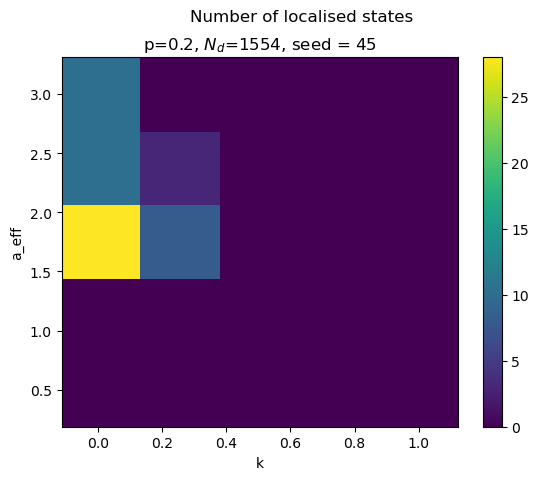

Plotting the heatmap took 0:00:00.670599


array([[ 0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.],
       [28.,  8.,  0.,  0.,  0.],
       [10.,  3.,  0.,  0.,  0.],
       [10.,  0.,  0.,  0.,  0.]])

In [32]:
heatmap_localization(R=100,seed=45,p=.2,k_range=[0.01,1,5],a_eff_range=[0.5,3,5],spacing=1)